# BTC Liquidation Analysis

Computational analysis of liquidation patterns vs BTC price movements

In [1]:
import os, sys, warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

sys.path.append('../src')
load_dotenv('../.env')
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Setup complete")


✅ Setup complete


In [2]:
DAYS_BACK = 200
INTERVAL = "1H" 

now_utc = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
start_date = now_utc - timedelta(days=DAYS_BACK)
end_date = now_utc

print(f"📅 Analysis Period: {start_date:%Y-%m-%d %H:%M} → {end_date:%Y-%m-%d %H:%M}")
print(f"⏱️ Interval: {INTERVAL}")

os.environ['AGG_INTERVAL'] = INTERVAL  


📅 Analysis Period: 2025-03-04 11:00 → 2025-09-20 11:00
⏱️ Interval: 1H


In [3]:
from binance_fetch_price import fetch_binance_klines, _interval_binance

print("🔄 Fetching BTC price data...")
symbol = os.getenv("BINANCE_SYMBOL", "BTCUSDT")
interval = _interval_binance(INTERVAL)

price_df = fetch_binance_klines(symbol, start_date, end_date, interval)

price_path = Path("../data/raw/btc_price.csv")
price_path.parent.mkdir(parents=True, exist_ok=True)
price_df.to_csv(price_path, index=False)

print(f"✅ Fetched {len(price_df)} price records")
if not price_df.empty:
    print(f"📊 Price range: ${price_df['close'].min():.0f} – ${price_df['close'].max():.0f}")
    display(price_df.head())


🔄 Fetching BTC price data...
✅ Fetched 4801 price records
📊 Price range: $74810 – $123848


,timestamp_utc,open,high,low,close,volume
0,2025-03-04 11:59:59.999000+00:00,83971.93,84373.84,83698.11,83937.94,1132.88002
1,2025-03-04 12:59:59.999000+00:00,83937.93,83979.66,83248.66,83763.73,1007.91883
2,2025-03-04 13:59:59.999000+00:00,83763.73,83764.56,82300.00,82804.00,2427.20219
3,2025-03-04 14:59:59.999000+00:00,82804.00,84977.65,82062.06,83201.41,6008.25724
4,2025-03-04 15:59:59.999000+00:00,83201.40,83373.42,81500.00,82985.06,4824.82043


In [4]:
# Fetch Telegram Messages (same window), filter "Liquidated"
from fetch_telegram import fetch_telegram_messages

print("🔄 Fetching Telegram messages...")
msgs_df = await fetch_telegram_messages(
    start_date, end_date,
    channel=os.getenv("TELEGRAM_GROUP", "@WhaleBotRektd"),
    channel_id=(int(os.getenv("TELEGRAM_GROUP_ID")) if os.getenv("TELEGRAM_GROUP_ID") else None),
    substr_filter=os.getenv("FILTER_TEXT_CONTAINS", "Liquidated"),
    save_csv=True,
    out_path=Path("../data/raw/telegram_messages.csv"),
    hard_limit=None,
)

if msgs_df is not None and len(msgs_df) > 0:
    print("📊 Sample messages:")
    display(msgs_df.head())
else:
    print("⚠️ No messages fetched. If needed, fall back to demo rows and rerun parsing.")


🔄 Fetching Telegram messages...
Fetched 60228 liquidation messages from @WhaleBotRektd between 2025-03-04 11:00:00+00:00 and 2025-09-20 11:00:00+00:00. Saved: True -> ../data/raw/telegram_messages.csv
📊 Sample messages:


,message_id,timestamp_utc,text
0,332053,2025-03-04 11:33:55+00:00,📈[Bybit](http://whalebot.co/Bybit) liquidated ...
1,332054,2025-03-04 11:47:08+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...
2,332055,2025-03-04 11:47:09+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...
3,332057,2025-03-04 11:56:29+00:00,📉[Bybit](http://whalebot.co/Bybit) liquidated ...
4,332059,2025-03-04 12:01:17+00:00,📉[Bybit](http://whalebot.co/Bybit) liquidated ...


In [5]:
def load_and_process_data(interval: str) -> pd.DataFrame | None:
    """Load price & TG, parse liqs, aggregate per interval, merge with price, engineer features."""
    price_path = Path("../data/raw/btc_price.csv")
    msg_path = Path("../data/raw/telegram_messages.csv")
    if not price_path.exists():
        print("❌ Price data not found.")
        return None
    if not msg_path.exists():
        print("❌ Message data not found.")
        return None

    price_df = pd.read_csv(price_path, parse_dates=["timestamp_utc"]).sort_values("timestamp_utc")
    msg_df = pd.read_csv(msg_path, parse_dates=["timestamp_utc"]).sort_values("timestamp_utc")

    from parse_aggregate import parse_row
    parsed = msg_df["text"].apply(parse_row)
    msg_df["side"] = parsed.apply(lambda x: x[0])
    msg_df["amount_usd"] = parsed.apply(lambda x: x[1])

    liq_df = msg_df.dropna(subset=["side", "amount_usd"]).copy()
    btc_liq = liq_df[liq_df["text"].str.contains(r"\bBTC", case=False, na=False)]
    if btc_liq.empty:
        print("⚠️ No BTC liquidations found, using all liquidations")
        btc_liq = liq_df

    btc_liq = btc_liq.set_index("timestamp_utc").sort_index()
    rule = "1H" if interval.upper() == "1H" else "1D"

    agg = pd.DataFrame({
        "long_liq_usd":  btc_liq[btc_liq["side"] == "long"].resample(rule)["amount_usd"].sum(),
        "short_liq_usd": btc_liq[btc_liq["side"] == "short"].resample(rule)["amount_usd"].sum(),
        "long_count":    btc_liq[btc_liq["side"] == "long"].resample(rule)["side"].count(),
        "short_count":   btc_liq[btc_liq["side"] == "short"].resample(rule)["side"].count(),
    }).fillna(0.0).reset_index()

    tol = pd.Timedelta("30min") if rule == "1H" else pd.Timedelta("12h")
    dataset = pd.merge_asof(
        agg.sort_values("timestamp_utc"),
        price_df[["timestamp_utc", "close", "volume"]].sort_values("timestamp_utc"),
        on="timestamp_utc",
        direction="nearest",
        tolerance=tol
    ).dropna(subset=["close"])

    if dataset.empty:
        print("❌ No matching timestamps after merge")
        return None

    dataset = dataset.sort_values("timestamp_utc").reset_index(drop=True)
    dataset["net_liq_usd"]   = dataset["short_liq_usd"] - dataset["long_liq_usd"]  # >0 => net SHORT liqs
    dataset["total_liq_usd"] = dataset["short_liq_usd"] + dataset["long_liq_usd"]
    dataset["price_change"]       = dataset["close"].pct_change()
    dataset["price_change_next"]  = dataset["close"].pct_change().shift(-1)

    return dataset

data = load_and_process_data(INTERVAL)
if data is not None:
    print(f"📅 Data range: {data['timestamp_utc'].min()} → {data['timestamp_utc'].max()}")
    print(f"💰 Total liquidations: ${data['total_liq_usd'].sum():,.0f}")
    display(data.head())


📅 Data range: 2025-03-04 12:00:00+00:00 → 2025-09-20 07:00:00+00:00
💰 Total liquidations: $3,129,483,364


,timestamp_utc,long_liq_usd,short_liq_usd,long_count,short_count,close,volume,net_liq_usd,total_liq_usd,price_change,price_change_next
0,2025-03-04 12:00:00+00:00,215675.0,378793.0,1.0,2,83937.94,1132.88002,163118.0,594468.0,NaN,-0.002075
1,2025-03-04 13:00:00+00:00,1273233.0,201698.0,8.0,1,83763.73,1007.91883,-1071535.0,1474931.0,-0.002075,-0.011458
2,2025-03-04 14:00:00+00:00,2569848.0,1515278.0,18.0,16,82804.00,2427.20219,-1054570.0,4085126.0,-0.011458,0.004799
3,2025-03-04 15:00:00+00:00,3649846.0,1582301.0,7.0,9,83201.41,6008.25724,-2067545.0,5232147.0,0.004799,-0.002600
4,2025-03-04 16:00:00+00:00,256447.0,123474.0,3.0,2,82985.06,4824.82043,-132973.0,379921.0,-0.002600,0.006872


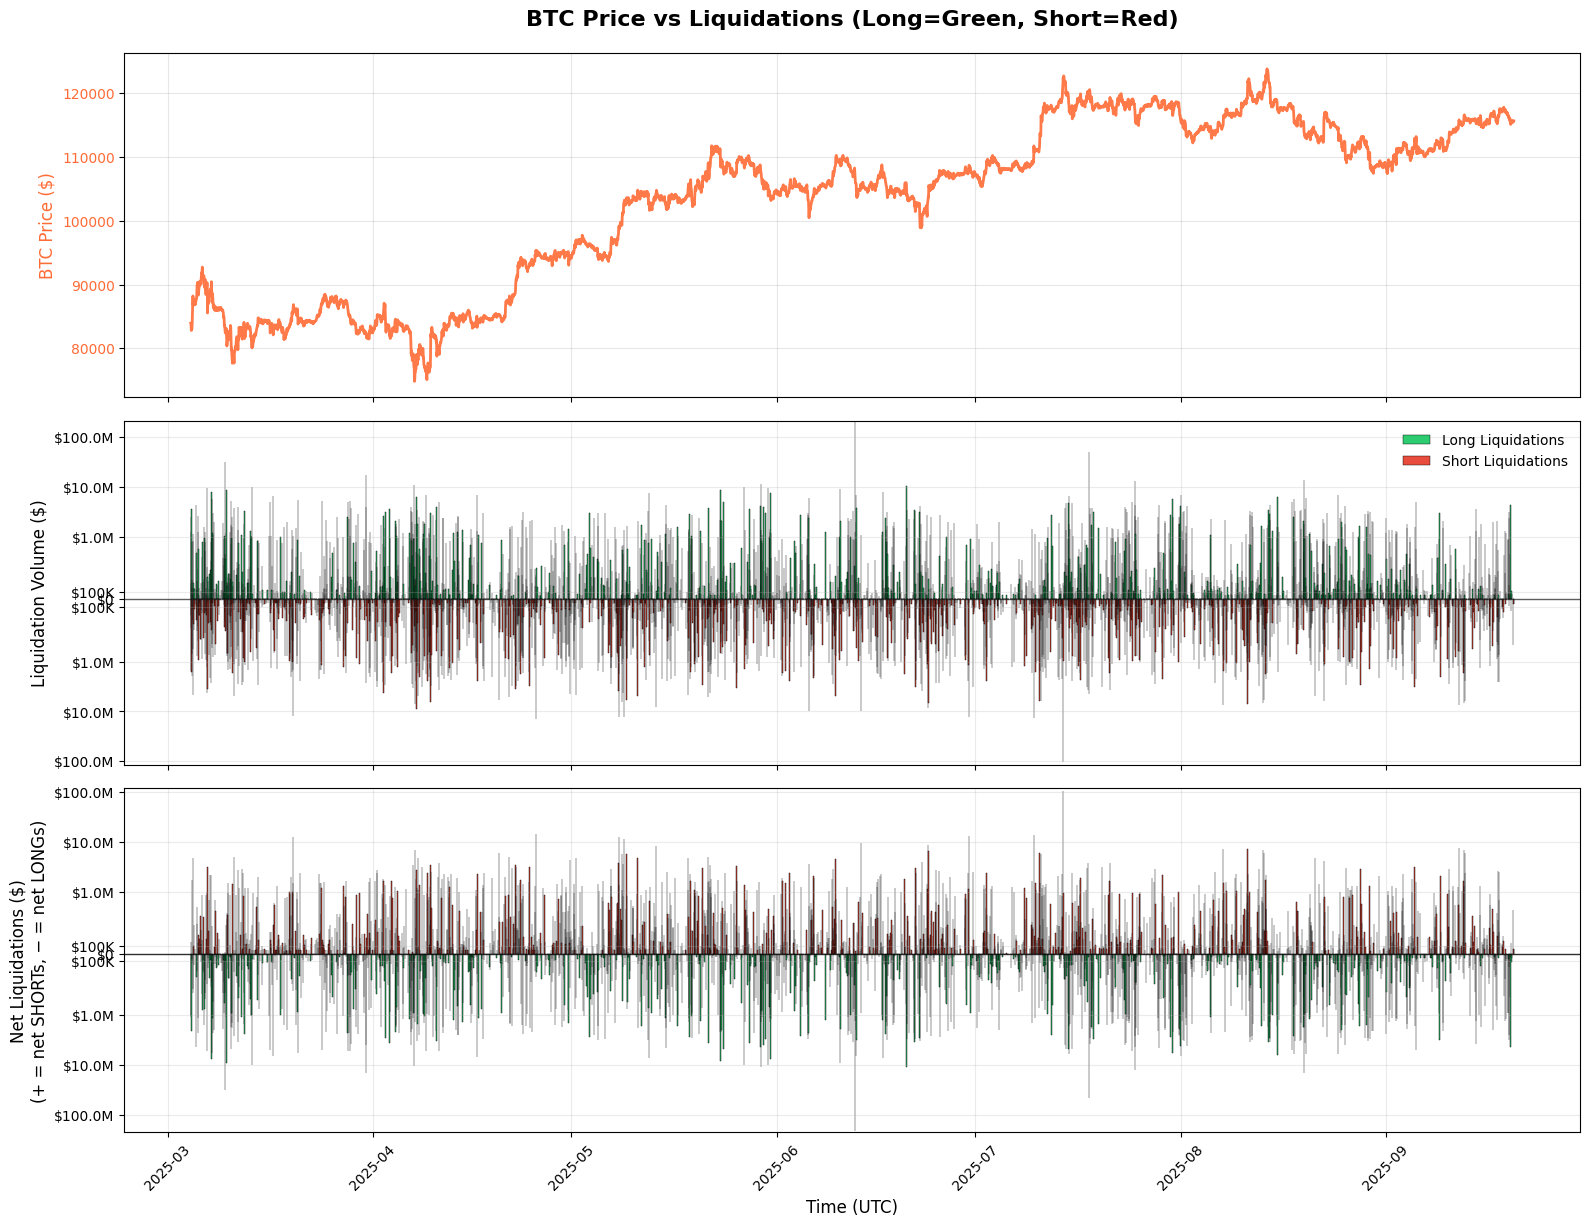

💾 Saved timeline visualization (symlog scale for readability)


In [6]:
# Visualization 1: Price vs Liquidations Timeline (with robust scaling)
if data is not None and len(data) > 0:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    # 1) BTC price
    ax1.plot(data['timestamp_utc'], data['close'], color='#FF6B35', linewidth=2, alpha=0.9)
    ax1.set_ylabel('BTC Price ($)', fontsize=12, color='#FF6B35')
    ax1.tick_params(axis='y', labelcolor='#FF6B35')
    ax1.set_title('BTC Price vs Liquidations (Long=Green, Short=Red)', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)

    # Bar width per interval - made wider for better visibility
    width = pd.Timedelta(minutes=50) if INTERVAL.upper() == "1H" else pd.Timedelta(days=0.9)

    # Precompute values
    long_usd  = data['long_liq_usd'].astype(float)
    short_usd = data['short_liq_usd'].astype(float)
    net_usd   = data['net_liq_usd'].astype(float)

    # ------- Robust scaling: symmetric log for liquidation axes -------
    # Choose linthresh from lower percentile to make small bars more visible
    def _linthresh(series, default=1e4):
        s = series.replace([np.inf, -np.inf], np.nan).dropna().abs()
        s = s[s > 0]
        if len(s) == 0:
            return default
        q = float(s.quantile(0.75))  # Use 75th percentile instead of 95th
        return max(default, q)  # at least default

    linthresh_liq = _linthresh(pd.concat([long_usd, short_usd]), default=1e4)  # Lower default threshold
    linthresh_net = _linthresh(net_usd, default=1e4)  # Lower default threshold

    # 2) Long (green, positive) vs Short (red, plotted negative) bars
    ax2.bar(data['timestamp_utc'], long_usd,  width=width,
            alpha=1.0, color='#2ecc71', label='Long Liquidations', edgecolor='black', linewidth=0.3)
    ax2.bar(data['timestamp_utc'], -short_usd, width=width,
            alpha=1.0, color='#e74c3c', label='Short Liquidations', edgecolor='black', linewidth=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.6, linewidth=1)
    ax2.set_ylabel('Liquidation Volume ($)', fontsize=12)
    ax2.legend(loc='upper right', frameon=False)
    ax2.grid(True, alpha=0.25)

    # Apply symmetric log scale so small bars stand out while big spikes compress
    ax2.set_yscale('symlog', linthresh=linthresh_liq)

    ax2.yaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, p: f'${abs(x)/1e6:.1f}M' if abs(x) >= 1e6 else f'${abs(x)/1e3:.0f}K' if abs(x) >= 1e3 else f'${int(abs(x))}'
    ))

    # 3) Net Liquidations (net = short - long)
    colors = ['#e74c3c' if v > 0 else '#2ecc71' if v < 0 else '#95a5a6' for v in net_usd]
    ax3.bar(data['timestamp_utc'], net_usd, width=width, alpha=1.0, color=colors, edgecolor='black', linewidth=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
    ax3.set_ylabel('Net Liquidations ($)\n(+ = net SHORTs, − = net LONGs)', fontsize=12)
    ax3.set_xlabel('Time (UTC)', fontsize=12)
    ax3.grid(True, alpha=0.25)

    ax3.set_yscale('symlog', linthresh=linthresh_net)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, p: f'${abs(x)/1e6:.1f}M' if abs(x) >= 1e6 else f'${abs(x)/1e3:.0f}K' if abs(x) >= 1e3 else f'${int(abs(x))}'
    ))

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    fig.savefig('../data/processed/liquidation_timeline.png', dpi=500, bbox_inches='tight')
    print("💾 Saved timeline visualization (symlog scale for readability)")


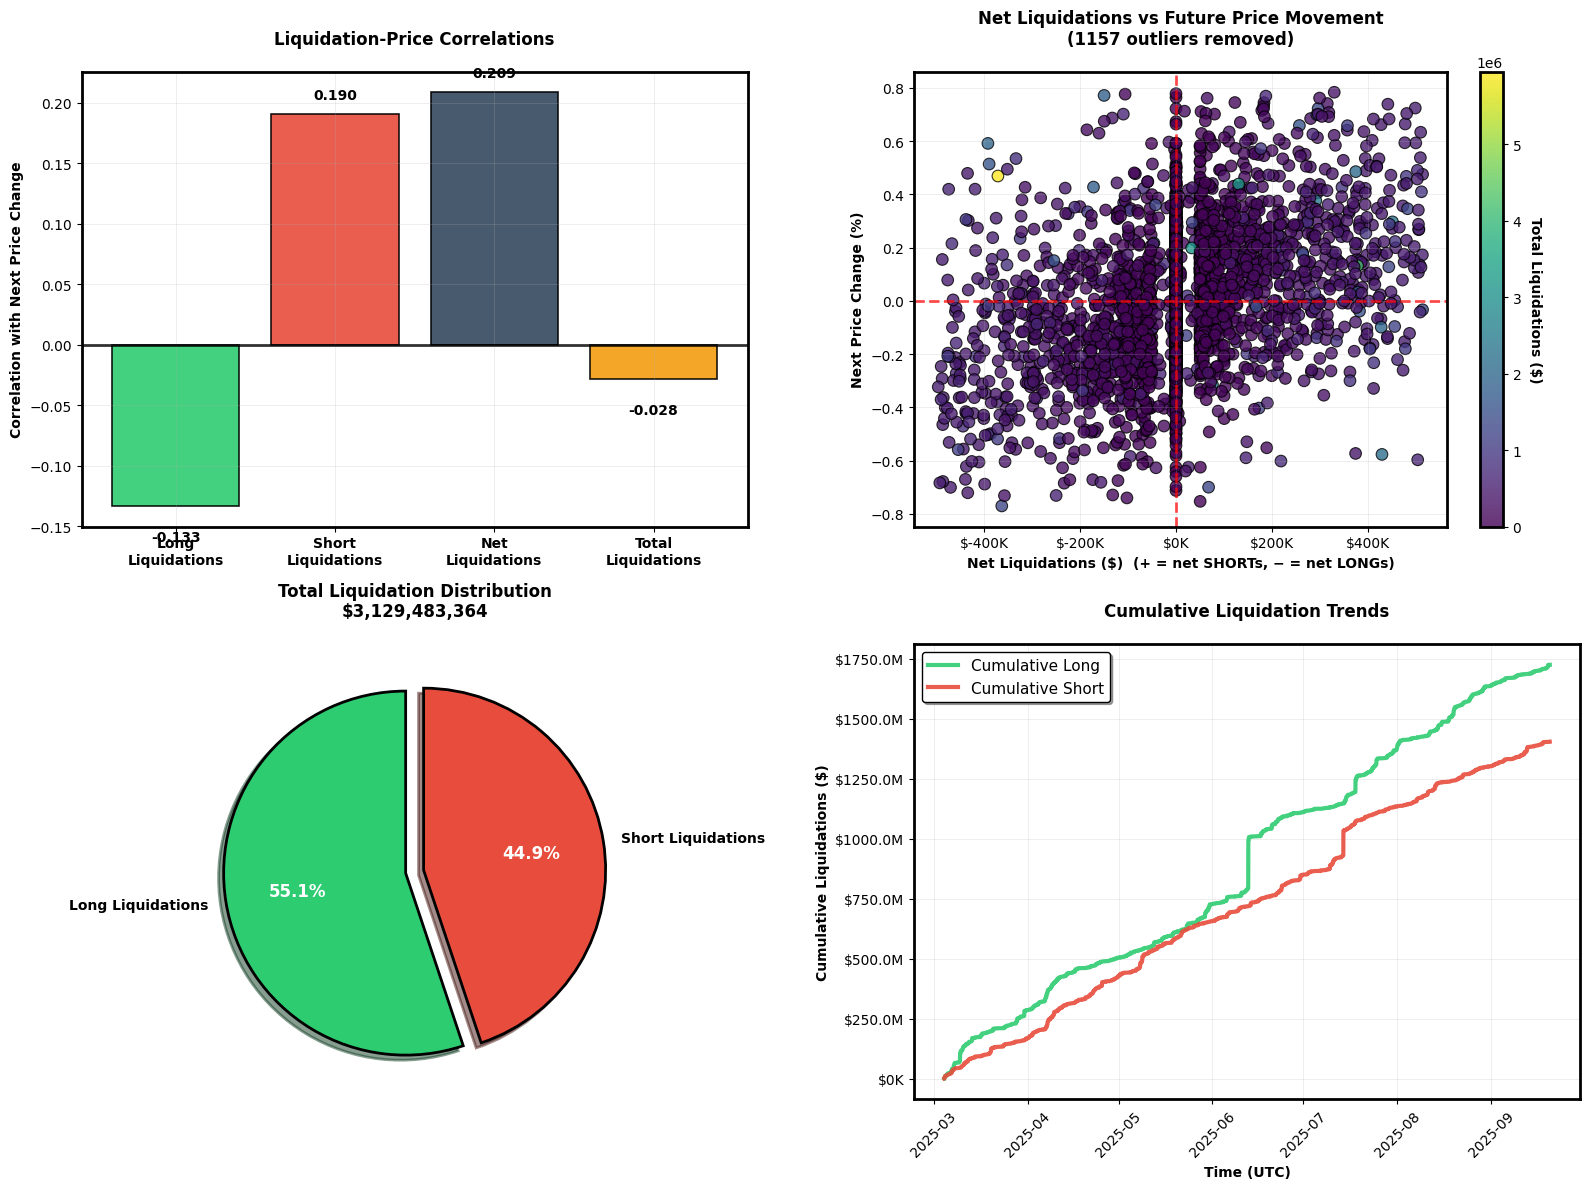

💾 Saved correlation analysis

📊 CORRELATION SUMMARY:
Long Liquidations: -0.1334 (Moderate Negative)
Short Liquidations: 0.1902 (Moderate Positive)
Net Liquidations: 0.2085 (Moderate Positive)
Total Liquidations: -0.0281 (Weak Negative)


In [9]:
# Visualization 2: Correlation Analysis
if data is not None and len(data) > 1:
    correlations = {
        'Long Liquidations':  data['long_liq_usd'].corr(data['price_change_next']),
        'Short Liquidations': data['short_liq_usd'].corr(data['price_change_next']),
        'Net Liquidations':   data['net_liq_usd'].corr(data['price_change_next']),
        'Total Liquidations': data['total_liq_usd'].corr(data['price_change_next'])
    }

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1) Correlation bars
    corr_names = list(correlations.keys())
    corr_values = [correlations[k] for k in corr_names]
    colors = ['#2ecc71', '#e74c3c', '#34495e', '#f39c12']  # long green, short red, net gray-blue, total orange
    bars = ax1.bar(range(len(corr_names)), corr_values, color=colors, alpha=0.9, edgecolor='black', linewidth=1.2)
    ax1.set_xticks(range(len(corr_names)))
    ax1.set_xticklabels([name.replace(' ', '\n') for name in corr_names], fontweight='bold')
    ax1.set_ylabel('Correlation with Next Price Change', fontweight='bold')
    ax1.set_title('Liquidation-Price Correlations', fontweight='bold', pad=20)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    
    # Add dark border frame
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    for bar, val in zip(bars, corr_values):
        if not pd.isna(val):
            ax1.text(bar.get_x() + bar.get_width()/2, val + (0.01 if val >= 0 else -0.02),
                    f'{val:.3f}', ha='center', va='bottom' if val >= 0 else 'top', fontweight='bold')

    # 2) Net vs next price change (with outlier removal)
    valid = data.dropna(subset=['net_liq_usd', 'price_change_next'])
    if len(valid) > 0:
        # Remove outliers using IQR method for better visualization
        def remove_outliers(df, columns, factor=1.5):
            df_clean = df.copy()
            for col in columns:
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - factor * IQR
                upper_bound = Q3 + factor * IQR
                df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
            return df_clean
        
        # Apply outlier removal
        valid_clean = remove_outliers(valid, ['net_liq_usd', 'price_change_next'], factor=2.0)
        n_removed = len(valid) - len(valid_clean)
        
        sc = ax2.scatter(valid_clean['net_liq_usd'], valid_clean['price_change_next']*100,
                         c=valid_clean['total_liq_usd'], cmap='viridis', alpha=0.8,
                         s=70, edgecolors='black', linewidth=0.8)
        ax2.set_xlabel('Net Liquidations ($)  (+ = net SHORTs, − = net LONGs)', fontweight='bold')
        ax2.set_ylabel('Next Price Change (%)', fontweight='bold')
        ax2.set_title(f'Net Liquidations vs Future Price Movement\n({n_removed} outliers removed)', 
                     fontweight='bold', pad=20)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.grid(True, alpha=0.3, linewidth=0.5)
        
        # Add dark border frame
        for spine in ax2.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
        
        cbar = plt.colorbar(sc, ax=ax2)
        cbar.set_label('Total Liquidations ($)', rotation=270, labelpad=15, fontweight='bold')
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(2)
        
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(
            lambda x, p: f'${x/1e6:.1f}M' if abs(x) >= 1e6 else f'${x/1e3:.0f}K'))

    # 3) Distribution
    long_total, short_total = data['long_liq_usd'].sum(), data['short_liq_usd'].sum()
    if long_total > 0 or short_total > 0:
        wedges, texts, autotexts = ax3.pie([long_total, short_total], labels=['Long Liquidations', 'Short Liquidations'],
                colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%', startangle=90,
                explode=(0.05, 0.05), shadow=True, 
                wedgeprops=dict(linewidth=2, edgecolor='black'))
        
        # Enhance text styling
        for text in texts:
            text.set_fontweight('bold')
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)
            
        ax3.set_title(f'Total Liquidation Distribution\n${(long_total + short_total):,.0f}', 
                     fontweight='bold', pad=20)
        
        # Add dark border frame
        for spine in ax3.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

    # 4) Cumulative
    dsorted = data.sort_values('timestamp_utc')
    ax4.plot(dsorted['timestamp_utc'], dsorted['long_liq_usd'].cumsum(),
             color='#2ecc71', linewidth=3, label='Cumulative Long', alpha=0.9)
    ax4.plot(dsorted['timestamp_utc'], dsorted['short_liq_usd'].cumsum(),
             color='#e74c3c', linewidth=3, label='Cumulative Short', alpha=0.9)
    ax4.set_xlabel('Time (UTC)', fontweight='bold')
    ax4.set_ylabel('Cumulative Liquidations ($)', fontweight='bold')
    ax4.set_title('Cumulative Liquidation Trends', fontweight='bold', pad=20)
    ax4.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, 
              edgecolor='black', facecolor='white')
    ax4.grid(True, alpha=0.3, linewidth=0.5)
    ax4.tick_params(axis='x', rotation=45, labelsize=10)
    ax4.tick_params(axis='y', labelsize=10)
    
    # Add dark border frame
    for spine in ax4.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
        
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))

    plt.tight_layout()
    plt.show()
    fig.savefig('../data/processed/correlation_analysis.png', dpi=300, bbox_inches='tight')
    print("💾 Saved correlation analysis")

    print("\n📊 CORRELATION SUMMARY:")
    print("=" * 40)
    for name, corr in correlations.items():
        if not pd.isna(corr):
            strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
            direction = "Positive" if corr > 0 else "Negative"
            print(f"{name}: {corr:.4f} ({strength} {direction})")
        else:
            print(f"{name}: No correlation (insufficient data)")


In [8]:
# === Event-study tables: forward returns after big liquidation spikes ===
import numpy as np
import pandas as pd
from pathlib import Path

def forward_return(close: pd.Series, k: int) -> pd.Series:
    return (close.shift(-k) - close) / close

def spike_threshold(series: pd.Series, q: float) -> float:
    s = series.fillna(0.0)
    s = s[s > 0]
    return float(s.quantile(q)) if len(s) else float("inf")

def run_event_study(df: pd.DataFrame, q: float, horizons: list[int]) -> pd.DataFrame:
    long_thr  = spike_threshold(df["long_liq_usd"],  q=q)
    short_thr = spike_threshold(df["short_liq_usd"], q=q)

    flags = {
        "LONG_SPIKE":  (df["long_liq_usd"]  >= long_thr)  if np.isfinite(long_thr)  else pd.Series(False, index=df.index),
        "SHORT_SPIKE": (df["short_liq_usd"] >= short_thr) if np.isfinite(short_thr) else pd.Series(False, index=df.index),
    }

    rows = []
    for label, mask in flags.items():
        idx = df.index[mask.fillna(False)]
        for k in horizons:
            fwd = forward_return(df["close"], k)
            vals = fwd.loc[idx].dropna()
            rows.append({
                "event": label,
                "horizon": k,
                "n_events": int(len(vals)),
                "mean_fwd_ret": float(vals.mean()) if len(vals) else np.nan,
                "median_fwd_ret": float(vals.median()) if len(vals) else np.nan,
                "hit_rate_pos": float((vals > 0).mean()) if len(vals) else np.nan,
                "threshold_usd": long_thr if label=="LONG_SPIKE" else short_thr,
                "quantile": q
            })

    # baseline for comparison
    for k in horizons:
        fwd = forward_return(df["close"], k).dropna()
        rows.append({
            "event": "BASELINE_ALL",
            "horizon": k,
            "n_events": int(len(fwd)),
            "mean_fwd_ret": float(fwd.mean()),
            "median_fwd_ret": float(fwd.median()),
            "hit_rate_pos": float((fwd > 0).mean()),
            "threshold_usd": np.nan,
            "quantile": q
        })

    out = pd.DataFrame(rows).sort_values(["event", "horizon"]).reset_index(drop=True)
    return out

# choose horizons by interval
HORIZONS = [1, 3, 6, 12, 24] if INTERVAL.upper() == "1H" else [1, 2, 3, 5, 10]

ev95 = run_event_study(data, q=0.95, horizons=HORIZONS)
ev90 = run_event_study(data, q=0.90, horizons=HORIZONS)

# show tables
print("Top 5% spike events (q=0.95):")
display(ev95)

print("Top 10% spike events (q=0.90):")
display(ev90)

# save
outdir = Path("../data/processed"); outdir.mkdir(parents=True, exist_ok=True)
ev95.to_csv(outdir / "event_study_q95.csv", index=False)
ev90.to_csv(outdir / "event_study_q90.csv", index=False)
print("Saved:", outdir / "event_study_q95.csv", "and", outdir / "event_study_q90.csv")


Top 5% spike events (q=0.95):


,event,horizon,n_events,mean_fwd_ret,median_fwd_ret,hit_rate_pos,threshold_usd,quantile
0,BASELINE_ALL,1,4795,0.000076,0.000028,0.503858,NaN,0.95
1,BASELINE_ALL,3,4793,0.000229,0.000144,0.514918,NaN,0.95
2,BASELINE_ALL,6,4790,0.000458,0.000277,0.519624,NaN,0.95
3,BASELINE_ALL,12,4784,0.000860,0.000623,0.532191,NaN,0.95
4,BASELINE_ALL,24,4772,0.001658,0.001048,0.532272,NaN,0.95
5,LONG_SPIKE,1,90,-0.008054,-0.006374,0.155556,3304318.8,0.95
6,LONG_SPIKE,3,90,-0.005660,-0.005221,0.277778,3304318.8,0.95
7,LONG_SPIKE,6,90,-0.005182,-0.004471,0.344444,3304318.8,0.95
8,LONG_SPIKE,12,90,-0.004415,-0.004313,0.411111,3304318.8,0.95
9,LONG_SPIKE,24,89,-0.003599,-0.005038,0.393258,3304318.8,0.95


Top 10% spike events (q=0.90):


,event,horizon,n_events,mean_fwd_ret,median_fwd_ret,hit_rate_pos,threshold_usd,quantile
0,BASELINE_ALL,1,4795,0.000076,0.000028,0.503858,NaN,0.9
1,BASELINE_ALL,3,4793,0.000229,0.000144,0.514918,NaN,0.9
2,BASELINE_ALL,6,4790,0.000458,0.000277,0.519624,NaN,0.9
3,BASELINE_ALL,12,4784,0.000860,0.000623,0.532191,NaN,0.9
4,BASELINE_ALL,24,4772,0.001658,0.001048,0.532272,NaN,0.9
5,LONG_SPIKE,1,179,-0.006199,-0.005551,0.189944,2119996.6,0.9
6,LONG_SPIKE,3,179,-0.004489,-0.004130,0.284916,2119996.6,0.9
7,LONG_SPIKE,6,179,-0.004274,-0.004625,0.329609,2119996.6,0.9
8,LONG_SPIKE,12,179,-0.004169,-0.004522,0.379888,2119996.6,0.9
9,LONG_SPIKE,24,176,-0.003247,-0.004157,0.397727,2119996.6,0.9


Saved: ../data/processed/event_study_q95.csv and ../data/processed/event_study_q90.csv


In [ ]:
# Summary Dashboard
if data is not None and len(data) > 0:
    total_liq = data['total_liq_usd'].sum()
    long_liq  = data['long_liq_usd'].sum()
    short_liq = data['short_liq_usd'].sum()

    print("\n" + "="*60)
    print("📊 LIQUIDATION ANALYSIS SUMMARY")
    print("="*60)
    print(f"\n📅 Analysis Period:\n   From: {data['timestamp_utc'].min()}\n   To:   {data['timestamp_utc'].max()}")
    print(f"   Duration: {len(data)} {INTERVAL}-bars")

    print(f"\n💰 Liquidation Summary:")
    print(f"   Total: ${total_liq:,.0f}")
    if total_liq > 0:
        print(f"   Long:  ${long_liq:,.0f} ({long_liq/total_liq*100:.1f}%)")
        print(f"   Short: ${short_liq:,.0f} ({short_liq/total_liq*100:.1f}%)")

    print(f"\n📈 BTC Price Summary:")
    print(f"   Price Range: ${data['close'].min():,.0f} – ${data['close'].max():,.0f}")
    print(f"   Volatility (σ of returns): {data['price_change'].std()*100:.2f}%")

    print(f"\n🔍 Key Correlations (vs next return):")
    corr = {
        'Net → Future Price':   data['net_liq_usd'].corr(data['price_change_next']),
        'Long → Future Price':  data['long_liq_usd'].corr(data['price_change_next']),
        'Short → Future Price': data['short_liq_usd'].corr(data['price_change_next'])
    }
    for name, c in corr.items():
        if not pd.isna(c):
            strength = "Strong" if abs(c) > 0.3 else "Moderate" if abs(c) > 0.1 else "Weak"
            direction = "Positive" if c > 0 else "Negative"
            print(f"   {name}: {c:.4f} ({strength} {direction})")

    print("\n✅ Analysis Complete!")
    print("="*60)
else:
    print("❌ No data available for analysis")
